In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from datetime import datetime

from SALib.analyze import sobol
from ema_workbench import Samplers
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

## fixed policy experiment part

Since the global sensitivity analysis provides its own output the setup of the fixed_policy_experiment_generation is copied here instead of using the outpuy provided by that notebook.

In [2]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-7
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(7)

In [4]:
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

policies = [
    Policy(
        "policy 1",
        # Big RfR in most upstream location (based on the map in ring 1 (non-organic farming)) -
        # our client would prefer this, as they don't care about non-organic farming and it should 
        # significantly decrease flooding of ring 4 (town Gorssel).
        **dict(
            get_do_nothing_dict(),
            **{"0_RfR 0": 1}
            # **{"0_RfR 0": 1, "0_RfR 1": 1, "0_RfR 2": 1, "A.1_DikeIncrease 0": 5} - 
            # this was original "policy 1" - since the course manual states: (for RfR 
            #"Once activated, the project remains active.", I think ""0_RfR 1": 1, "0_RfR 2": 1" 
            # are redundant - but we should evaluate this.
        )
    ),
    Policy(
        "policy 2",
        # Second best alternative of RfR from ring 4 perspective. Some RfR made upstream, 
        # some downstream from them, but none on their area. We choose this to have some comparison for policy 1.
        **dict(
            get_do_nothing_dict(),
            **{"3_RfR 0": 1}
        )
    ),
    Policy(
        "policy 3",
        # Only hightening dikes in ring 4 by the middle height of 0.5m (5 decimeters).
        **dict(
            get_do_nothing_dict(),
            **{"A.4_DikeIncrease 0": 5}
        )
    ),
    Policy(
        "policy 4",
        # Only hightening dikes in ring 4 by maximum height of 1m for comparison with policy 3.
        **dict(
            get_do_nothing_dict(),
            **{"A.4_DikeIncrease 0": 10}
        )
    ),
    Policy(
        "policy 5",
        # policy 1 + policy 3 - trade-off between costs of projects and max safety. Note that making more RfR 
        # (outside of ring 4 though, as they don't want to give up land) 
        # and hightening the dikes in ring 4 by more than 0.5m would increase ring 4 safety even further, but
        # is unrealistic with limiteed budget and stakeholders' interests.
        **dict(
            get_do_nothing_dict(),
            **{"0_RfR 0": 1, "A.4_DikeIncrease 0": 5}
        )
    ),
]

## Global sensitvity analysis with SOBOL
https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html#More-advanced-sampling-techniques
https://emaworkbench.readthedocs.io/en/latest/examples/sample_sobol_lake_model.html

Global sensitivity shows the effect of variance in the input space. Sobol is used since it is easily available in the EMA workbench. A downside is that it is computationaly expensive compared to other methods. This was still managable so it was not a big drawback. 





In [5]:
n_scenarios = 32

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies, uncertainty_sampling=Samplers.SOBOL)

[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 1280 scenarios * 5 policies * 1 model(s) = 6400 experiments
100%|██████████████████████████████████████| 6400/6400 [39:30<00:00,  2.70it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [10]:
experiments, outcomes = results
problem = get_SALib_problem(dike_model.uncertainties)

### Total Expected Number of Deaths

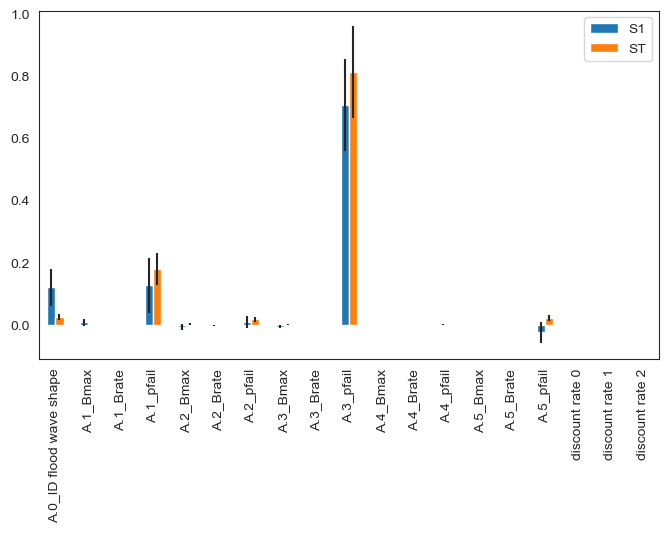

In [11]:
Si = sobol.analyze(problem, outcomes["Total Expected Number of Deaths"], calc_second_order=True, print_to_console=False)
scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)
plt.show()

### Total Expected Annual Damage

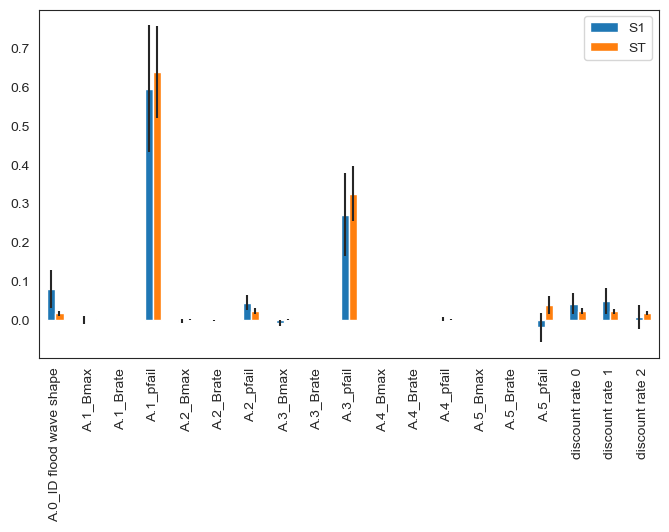

In [13]:
Si = sobol.analyze(problem, outcomes["Total Expected Annual Damage"], calc_second_order=True, print_to_console=False)

scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)
plt.show()

### A.4 Expected Annual Damage

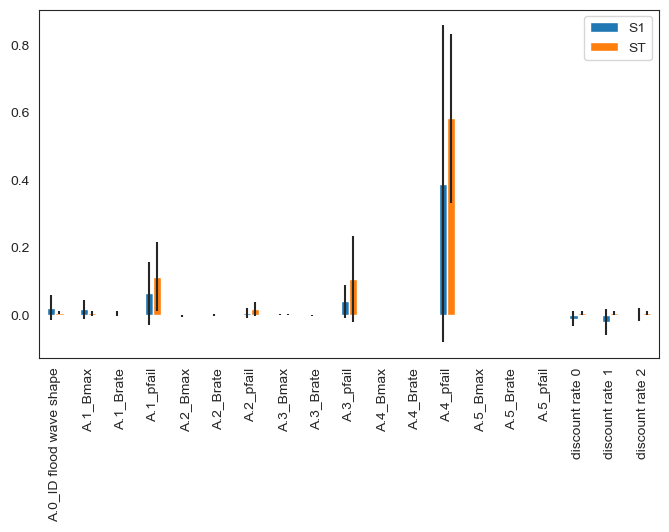

In [14]:
Si = sobol.analyze(problem, outcomes["A.4 Expected Annual Damage"], calc_second_order=True, print_to_console=False)

scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)
plt.show()

### A.4 Expected Number of Deaths

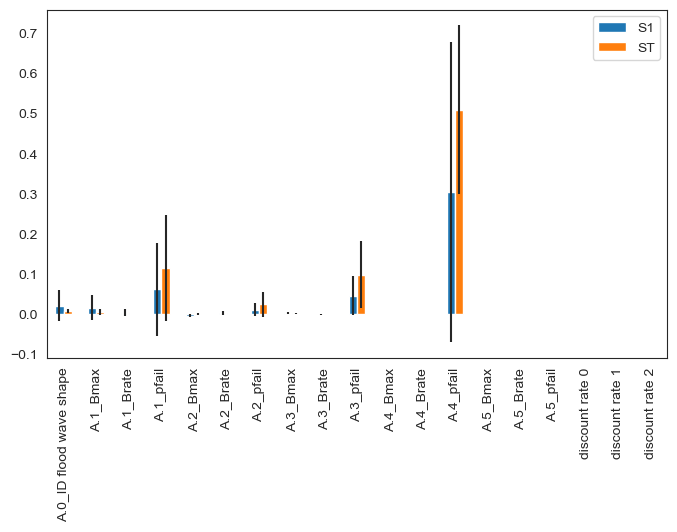

In [15]:
Si = sobol.analyze(problem, outcomes["A.4 Expected Number of Deaths"], calc_second_order=True, print_to_console=False)

scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)
plt.show()